# Model Baseline Notebook

This notebook trains baseline and improved models (or loads them from `models/`) and demonstrates predictions for movie pairs.

In [4]:
# basic imports and repo path fix (if notebook is inside /notebooks)
import sys
from pathlib import Path
repo_root = Path("..").resolve()  # adjust to '.' if you run this at repo root
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import json
print("Repo root:", repo_root)

Repo root: /workspaces/Group-1_Intro-to-DS-Programming


In [5]:
# Adjust path to your processed CSV location. Try a couple of common places.
data_path = Path("../Data/processed/movies_model.csv")
if not data_path.exists():
    data_path = Path("Data/processed/movies_model.csv")
if not data_path.exists():
    data_path = Path("../data/processed/movies_model.csv")
if not data_path.exists():
    data_path = Path("data/processed/movies_model.csv")

if not data_path.exists():
    raise FileNotFoundError(f"Could not find processed CSV in known locations. Looked at: {data_path}")

df = pd.read_csv(data_path)
print("Data loaded:", data_path)
print("Shape:", df.shape)
df.columns.tolist()

Data loaded: ../Data/processed/movies_model.csv
Shape: (5075, 15)


['Unnamed: 0',
 'name',
 'rating',
 'genre',
 'year',
 'score',
 'votes',
 'director',
 'writer',
 'star',
 'runtime',
 'decade',
 'gross',
 'budget',
 'company']

In [6]:
# Quick preview and a few summary stats
display(df.head(5))
if 'gross' in df.columns:
    print("gross summary:")
    display(df['gross'].describe())
if 'gross_adj' in df.columns:
    print("gross_adj summary:")
    display(df['gross_adj'].describe())

,Unnamed: 0,name,rating,genre,year,score,votes,director,writer,star,runtime,decade,gross,budget,company
0,0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,146.0,1980s,183.0,74.0,Warner Brothers
1,1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,104.0,1980s,229.0,18.0,Columbia Pictures
2,2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,124.0,1980s,2094.0,70.0,Luscasfilm
3,3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,88.0,1980s,325.0,14.0,Paramount Pictures
4,4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,98.0,1980s,155.0,23.0,Orion Pictures


gross summary:


count    5075.000000
mean      181.350739
std       293.302629
min         0.000000
25%        27.000000
50%        76.000000
75%       208.000000
max      4403.000000
Name: gross, dtype: float64

In [7]:
# If model artifacts aren't present, train them here (this uses your train functions).
from apputil import train_baseline, train_improved, load_processed

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

baseline_path = models_dir / "model_baseline.joblib"
improved_path = models_dir / "model_improved.joblib"

# If files are missing, run training using the same functions you used in train_models.py
if not baseline_path.exists() or not improved_path.exists():
    print("Model artifacts missing; training now...")
    # use the processed df we loaded above
    model_base, features_base, r2_base = train_baseline(df)
    joblib.dump({"model": model_base, "features": features_base, "r2": r2_base, "type": "baseline"}, baseline_path)
    print("Saved baseline ->", baseline_path)

    model_imp, features_imp, r2_imp = train_improved(df)
    joblib.dump({"model": model_imp, "features": features_imp, "r2": r2_imp, "type": "improved"}, improved_path)
    print("Saved improved ->", improved_path)
else:
    print("Model artifacts already present in models/")


Model artifacts missing; training now...
Saved baseline -> models/model_baseline.joblib
Saved improved -> models/model_improved.joblib


In [8]:
# Load artifacts and report metrics
art_base = joblib.load(baseline_path)
art_imp = joblib.load(improved_path)

print("Baseline artifact keys:", list(art_base.keys()))
print("Improved artifact keys:", list(art_imp.keys()))

print("\nBaseline R2:", art_base.get("r2"))
print("Improved R2:", art_imp.get("r2"))

# Show feature lists lengths
print("\nBaseline feature count:", len(art_base["features"]))
print("Improved feature count:", len(art_imp["features"]))


Baseline artifact keys: ['model', 'features', 'r2', 'type']
Improved artifact keys: ['model', 'features', 'r2', 'type']

Baseline R2: 0.2186823124657834
Improved R2: 0.5784615885093036

Baseline feature count: 24
Improved feature count: 1962


Top features (improved model):


,feature,importance
0,gross,0.309375
1,votes,0.239362
2,score,0.064150
3,runtime,0.061712
4,rating_R,0.033230
5,year,0.030029
6,genre_Animation,0.025537
7,rating_PG-13,0.019375
8,director_Anthony Russo,0.017579
9,director_James Cameron,0.015175


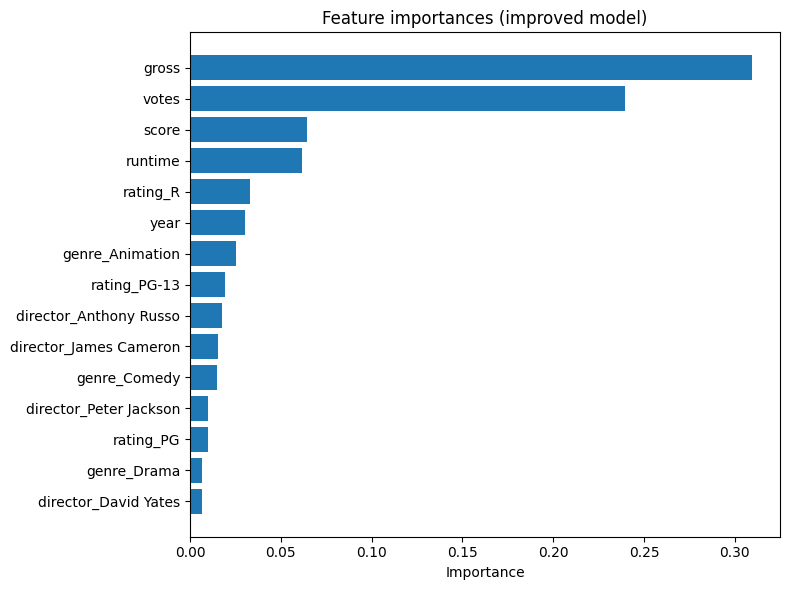

In [9]:
# Plot feature importances from the improved model (if available)
imp_model = art_imp["model"]
imp_feats = art_imp["features"]

if hasattr(imp_model, "feature_importances_"):
    importances = imp_model.feature_importances_
    # create a DataFrame and sort
    fi = pd.DataFrame({"feature": imp_feats, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)
    print("Top features (improved model):")
    display(fi.head(20))

    # plot top 15
    top = fi.head(15).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(top["feature"], top["importance"])
    plt.title("Feature importances (improved model)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Improved model has no feature_importances_ (not a tree-based model).")


In [10]:
# Demonstrate prediction on two rows (movie A vs movie B)
from apputil import _row_to_features

# pick two sample rows (change indices as needed)
idx_a = 0
idx_b = 1
ra = df.iloc[idx_a]
rb = df.iloc[idx_b]

print("Sample movies:")
print("A:", ra.get('name', ra.get('title', f'row {idx_a}')), "year:", ra.get('year'))
print("B:", rb.get('name', rb.get('title', f'row {idx_b}')), "year:", rb.get('year'))

# Use improved artifact for prediction demonstration
feat_imp = art_imp["features"]
mod_imp = art_imp["model"]

xa = _row_to_features(ra, feat_imp)[feat_imp]
xb = _row_to_features(rb, feat_imp)[feat_imp]

print("\nNon-zero features for A:")
display(xa.loc[:, (xa != 0).any()].to_dict('records')[0])

print("\nNon-zero features for B:")
display(xb.loc[:, (xb != 0).any()].to_dict('records')[0])

pred_a_imp = mod_imp.predict(xa)[0]
pred_b_imp = mod_imp.predict(xb)[0]
print(f"\nImproved model predicted gross for A: {pred_a_imp:,.2f}")
print(f"Improved model predicted gross for B: {pred_b_imp:,.2f}")

winner = ("A" if pred_a_imp > pred_b_imp else "B" if pred_b_imp > pred_a_imp else "Tie")
print("Predicted winner (improved):", winner)


Sample movies:
A: The Shining year: 1980
B: The Blue Lagoon year: 1980

=== Processing: The Shining ===

=== Processing: The Blue Lagoon ===

Non-zero features for A:


{'runtime': 146.0,
 'year': 1980.0,
 'score': 8.4,
 'votes': 927000.0,
 'gross': 183.0,
 'genre_Drama': 1,
 'rating_R': 1,
 'director_Stanley Kubrick': 1}


Non-zero features for B:


{'runtime': 104.0,
 'year': 1980.0,
 'score': 5.8,
 'votes': 65000.0,
 'gross': 229.0,
 'genre_Adventure': 1,
 'rating_R': 1,
 'director_Randal Kleiser': 1}


Improved model predicted gross for A: 324.56
Improved model predicted gross for B: 131.36
Predicted winner (improved): A


In [11]:
# Also compare baseline predictions using baseline artifact features
feat_base = art_base["features"]
mod_base = art_base["model"]

# Build x vectors aligned to baseline features
xa_base = _row_to_features(ra, feat_base)[feat_base]
xb_base = _row_to_features(rb, feat_base)[feat_base]

pred_a_base = mod_base.predict(xa_base)[0]
pred_b_base = mod_base.predict(xb_base)[0]

print("Baseline predicted gross A:", pred_a_base)
print("Baseline predicted gross B:", pred_b_base)
print("Baseline predicted winner:", "A" if pred_a_base > pred_b_base else "B" if pred_b_base > pred_a_base else "Tie")



=== Processing: The Shining ===

=== Processing: The Blue Lagoon ===
Baseline predicted gross A: 213.02214350169572
Baseline predicted gross B: 63.78486599601583
Baseline predicted winner: A


In [12]:
# Save a small results JSON for later reference
summary = {
    "baseline_r2": art_base.get("r2"),
    "improved_r2": art_imp.get("r2"),
    "sample_pair": {
        "idx_a": int(idx_a),
        "idx_b": int(idx_b),
        "pred_a_improved": float(pred_a_imp),
        "pred_b_improved": float(pred_b_imp),
        "pred_a_baseline": float(pred_a_base),
        "pred_b_baseline": float(pred_b_base),
    }
}
out_path = Path("models/summary_metrics.json")
out_path.write_text(json.dumps(summary, indent=2))
print("Wrote summary to", out_path)
display(summary)


Wrote summary to models/summary_metrics.json


{'baseline_r2': 0.2186823124657834,
 'improved_r2': 0.5784615885093036,
 'sample_pair': {'idx_a': 0,
  'idx_b': 1,
  'pred_a_improved': 324.5601462361184,
  'pred_b_improved': 131.36473218456487,
  'pred_a_baseline': 213.02214350169572,
  'pred_b_baseline': 63.78486599601583}}